## Import Dependencies

In [ ]:
!pip install tensorflow==2.4.0
import tensorflow as tf
tf.__version__
import os
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
!nvidia-smi
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

--2022-01-23 17:48:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-23 17:48:11 (125 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]

Sun Jan 23 17:48:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr

## Get data

In [ ]:
(train_data, test_data), ds_info = tfds.load(
    name = "food101", split = ['train', 'validation'],
    shuffle_files = True, as_supervised = True,
    with_info = True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteL7HTY7/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteL7HTY7/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features['label'].names
len(class_names)

101

## Preprocess the data

In [ ]:
train_data

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
def preprocess_img(image, label, img_shape = 224):

  image = tf.image.resize(
      image, [img_shape, img_shape]
  )
  return tf.cast(image, tf.float32), label

In [ ]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [ ]:
## Tensorboard Callback

checkpoint_path = "model_checkpoint/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor = "val_accuracy",
    save_best_only = True, save_weights_only = True,
    verbose = 1
)

# Mixed Precision Training

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


## Create a base model

In [ ]:
import tensorflow as tf
tf.__version__

'2.4.0'

In [ ]:
# Create data augmentation stage using the sequential api
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
data_augmentation = keras.Sequential([
                                      
                                      preprocessing.RandomFlip("horizontal"),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomZoom(0.2)

], name = "data_augmentation")

In [ ]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape = input_shape, name = "input_layer")

x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)

outputs = layers.Activation("softmax", dtype = tf.float32, name = "softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

71688192/71686520 [==============================] - 1s 0us/step


In [ ]:
# compile the model

model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, None, None, 1792)  17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               181093    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 17,854,916
Trainable params: 181,093
Non-trainable params: 17,673,823
___________________________________________

In [ ]:
# Check mixed_precision policy for layers

for layer in model.layers:

  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
data_augmentation True float32 <Policy "mixed_float16">
efficientnetb4 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Fit the model

history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs = 5,
                                                     steps_per_epoch = len(train_data),
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15*len(test_data)),
                                                     callbacks = [create_tensorboard_callback(dir_name= "training_logs",
                                                                                              experiment_name = "efficientnetB0_mixed_precision_food_vision"),
                                                                  model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetB0_mixed_precision_food_vision/20220123-175410
Epoch 1/5
2368/2368 [==============================] - 221s 85ms/step - loss: 2.6924 - accuracy: 0.3750 - val_loss: 1.4559 - val_accuracy: 0.6247

Epoch 00001: val_accuracy improved from -inf to 0.62474, saving model to model_checkpoint/cp.ckpt
Epoch 2/5
2368/2368 [==============================] - 196s 82ms/step - loss: 1.8187 - accuracy: 0.5398 - val_loss: 1.3228 - val_accuracy: 0.6536

Epoch 00002: val_accuracy improved from 0.62474 to 0.65360, saving model to model_checkpoint/cp.ckpt
Epoch 3/5
2368/2368 [==============================] - 194s 82ms/step - loss: 1.6854 - accuracy: 0.5678 - val_loss: 1.3064 - val_accuracy: 0.6626

Epoch 00003: val_accuracy improved from 0.65360 to 0.66261, saving model to model_checkpoint/cp.ckpt
Epoch 4/5
2368/2368 [==============================] - 194s 82ms/step - loss: 1.6142 - accuracy: 0.5843 - val_loss: 1.2706 - val_accuracy: 0.6639

Epoch 

In [ ]:
# Save the model
from google.colab import drive
drive.mount('/content/drive')
model.save("/content/drive/My Drive/Tensorflow-Developer-Certificate/Models/101_food_classes_base_model_mxd_prec")

Mounted at /content/drive
INFO:tensorflow:Assets written to: /content/drive/My Drive/Tensorflow-Developer-Certificate/Models/101_food_classes_base_model_mxd_prec/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Tensorflow-Developer-Certificate/Models/101_food_classes_base_model_mxd_prec/assets


In [ ]:
# Evaluate the model
model.evaluate(test_data)


790/790 [==============================] - 57s 72ms/step - loss: 1.2615 - accuracy: 0.6618


[1.2615166902542114, 0.6617822051048279]

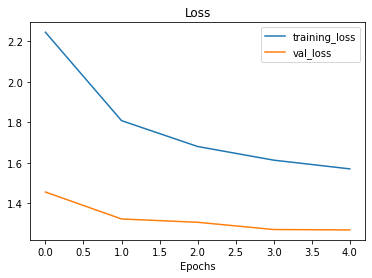

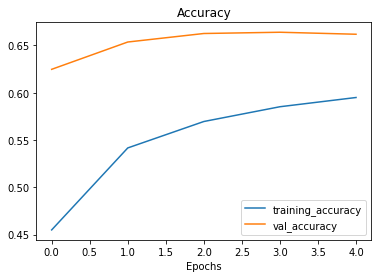

In [ ]:
# Plot loss curves
plot_loss_curves(history_101_food_classes_feature_extract)

## Tune the base model
- Set the last 5 layers of the model to trainable

In [ ]:
base_model.trainable = False
base_model.trainable = True

for layers in base_model.layers[:-3]:
  layers.trainable = False

In [ ]:
# Compile the model
model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [ ]:
# Fit the model
history_101_food_classes_tuned = model.fit(
    train_data,
    steps_per_epoch = len(train_data),
    epochs = 10,
    validation_data = test_data,
    validation_steps = int(0.15*len(test_data)),
    initial_epoch = history_101_food_classes_feature_extract.epoch[-1],
    callbacks = [create_tensorboard_callback(dir_name= "training_logs",
                                              experiment_name = "efficientnetB0_mixed_precision_food_vision_tuned"),
                                              model_checkpoint]
)

Saving TensorBoard log files to: training_logs/efficientnetB0_mixed_precision_food_vision_tuned/20220123-183323
Epoch 5/10
2368/2368 [==============================] - 213s 85ms/step - loss: 1.8178 - accuracy: 0.5384 - val_loss: 1.2858 - val_accuracy: 0.6581

Epoch 00005: val_accuracy did not improve from 0.66393
Epoch 6/10
2368/2368 [==============================] - 200s 84ms/step - loss: 1.5459 - accuracy: 0.5971 - val_loss: 1.2801 - val_accuracy: 0.6597

Epoch 00006: val_accuracy did not improve from 0.66393
Epoch 7/10
2368/2368 [==============================] - 199s 84ms/step - loss: 1.3900 - accuracy: 0.6290 - val_loss: 1.2458 - val_accuracy: 0.6692

Epoch 00007: val_accuracy improved from 0.66393 to 0.66923, saving model to model_checkpoint/cp.ckpt
Epoch 8/10
2368/2368 [==============================] - 199s 84ms/step - loss: 1.2716 - accuracy: 0.6582 - val_loss: 1.2599 - val_accuracy: 0.6766

Epoch 00008: val_accuracy improved from 0.66923 to 0.67664, saving model to model_che

In [ ]:
# Evaluate the model
model.evaluate(test_data)

790/790 [==============================] - 55s 70ms/step - loss: 1.2669 - accuracy: 0.6745


[1.2668876647949219, 0.6745346784591675]

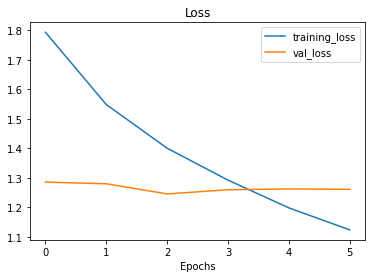

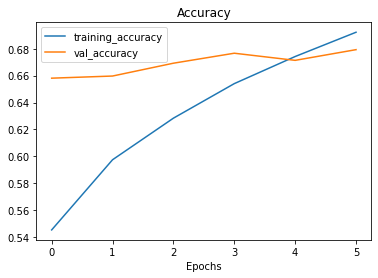

In [ ]:
# Plot loss curves
plot_loss_curves(history_101_food_classes_tuned)

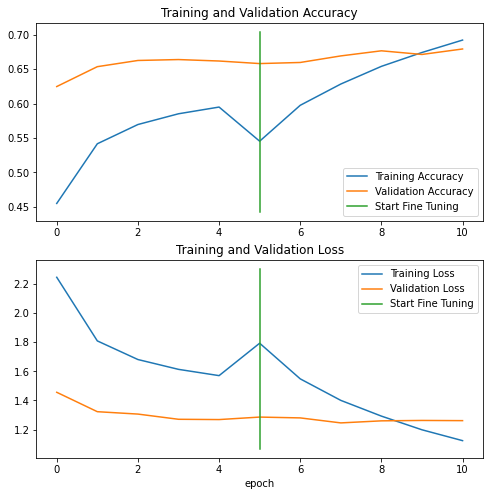

In [ ]:
# Compare the plots of loss curves

compare_historys(
    history_101_food_classes_feature_extract,
    history_101_food_classes_tuned,
    initial_epochs = 6

)

In [ ]:
model.save("/content/drive/My Drive/Tensorflow-Developer-Certificate/Models/101_food_classes_tuned_model_mxd_prec")

INFO:tensorflow:Assets written to: /content/drive/My Drive/Tensorflow-Developer-Certificate/Models/101_food_classes_tuned_model_mxd_prec/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Tensorflow-Developer-Certificate/Models/101_food_classes_tuned_model_mxd_prec/assets


## Tune the Learning Rate

In [ ]:
# Compile the model
model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics = ['accuracy']
)

In [ ]:
# Fit the model from the last epoch
history_101_food_classes_tuned_lr = model.fit(
    train_data,
    steps_per_epoch = len(train_data),
    epochs = 15,
    validation_data = test_data,
    validation_steps = int(0.15*len(test_data)),
    initial_epoch = history_101_food_classes_tuned.epoch[-1],
    callbacks = [create_tensorboard_callback(dir_name= "training_logs",
                                              experiment_name = "efficientnetB0_mixed_precision_food_vision_tuned_tf"),
                                              model_checkpoint]
)

Saving TensorBoard log files to: training_logs/efficientnetB0_mixed_precision_food_vision_tuned_tf/20220123-185532
Epoch 10/15
2368/2368 [==============================] - 214s 85ms/step - loss: 0.9094 - accuracy: 0.7478 - val_loss: 1.1215 - val_accuracy: 0.7097

Epoch 00010: val_accuracy improved from 0.67929 to 0.70975, saving model to model_checkpoint/cp.ckpt
Epoch 11/15
2368/2368 [==============================] - 200s 84ms/step - loss: 0.7710 - accuracy: 0.7853 - val_loss: 1.1258 - val_accuracy: 0.7082

Epoch 00011: val_accuracy did not improve from 0.70975
Epoch 12/15
2368/2368 [==============================] - 198s 83ms/step - loss: 0.7295 - accuracy: 0.7985 - val_loss: 1.1268 - val_accuracy: 0.7090

Epoch 00012: val_accuracy did not improve from 0.70975
Epoch 13/15
2368/2368 [==============================] - 200s 84ms/step - loss: 0.6991 - accuracy: 0.8043 - val_loss: 1.1304 - val_accuracy: 0.7124

Epoch 00013: val_accuracy improved from 0.70975 to 0.71239, saving model to mo

In [ ]:
# Evaluate the model
model.evaluate(test_data)

790/790 [==============================] - 55s 69ms/step - loss: 1.1177 - accuracy: 0.7152


[1.1176784038543701, 0.7152079343795776]

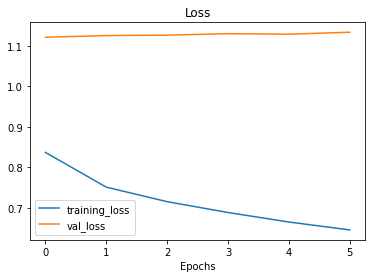

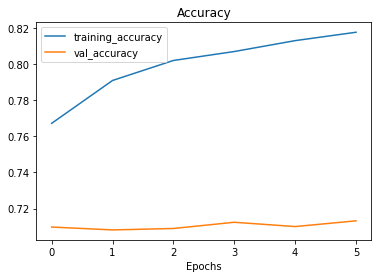

In [ ]:
# Plot loss curves
plot_loss_curves(history_101_food_classes_tuned_lr)

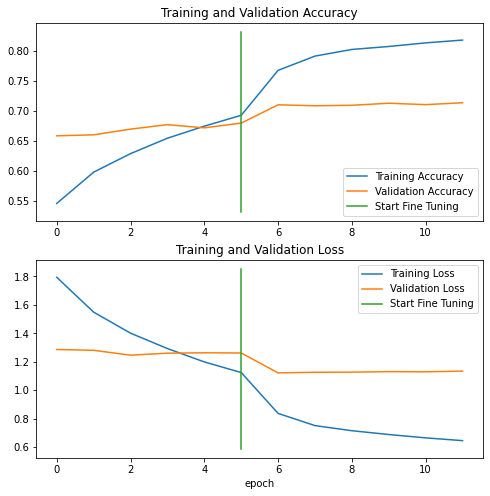

In [ ]:
# Compare histories
compare_historys(
    history_101_food_classes_tuned,
    history_101_food_classes_tuned_lr,
    initial_epochs = 6
)

In [ ]:
# Save the model
model.save("/content/drive/My Drive/Tensorflow-Developer-Certificate/Models/101_food_classes_tuned_model_mxd_prec")

INFO:tensorflow:Assets written to: /content/drive/My Drive/Tensorflow-Developer-Certificate/Models/101_food_classes_tuned_model_mxd_prec/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Tensorflow-Developer-Certificate/Models/101_food_classes_tuned_model_mxd_prec/assets
